# NYC Taxi Fare Prediction

Ссылка к данным: https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/data

### Устанавливаем нужные библиотеки

In [ ]:
!pip3 install pandas
!pip3 install matplotlib
!pip3 install seaborn
!pip3 install numpy
!pip3 install sklearn
!pip3 install haversine

### Импортируем

In [143]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn as sk
import haversine

### Читаем данные из датасета. Ограничиваем до миллиона строк для экономии памяти

In [145]:
df = pd.read_csv('train.csv', nrows=1e6)
df.to_csv('df.csv', index=False)
df.shape

(1000000, 8)

In [115]:
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


### Фильтруем данные

##### Ключ не понадобится, поэтому удаляем, а начало поездки переводим из object в datetime, чтобы смогли в дальнейшем работать

In [116]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   key                1000000 non-null  object 
 1   fare_amount        1000000 non-null  float64
 2   pickup_datetime    1000000 non-null  object 
 3   pickup_longitude   1000000 non-null  float64
 4   pickup_latitude    1000000 non-null  float64
 5   dropoff_longitude  999990 non-null   float64
 6   dropoff_latitude   999990 non-null   float64
 7   passenger_count    1000000 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 61.0+ MB


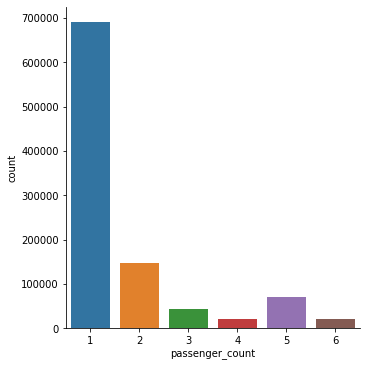

In [141]:
# Удаляем столбец ключ
df.drop(columns='key', inplace=True, errors='ignore')

# Удаляем строчки с null
df.dropna(inplace=True)

# Переводим столбец pickup_datetime из object в datetime формат
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], format='%Y-%m-%d %H:%M:%S UTC')

# Оставляем поездки до 8 пассажиров
df = df[df['passenger_count'].between(1, 8)]

passenger_count = df['passenger_count']
sns.catplot(x=passenger_count, kind='count', data=df)

/home/xeno/anaconda3/envs/rstudio/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='fare_amount', ylabel='Density'>

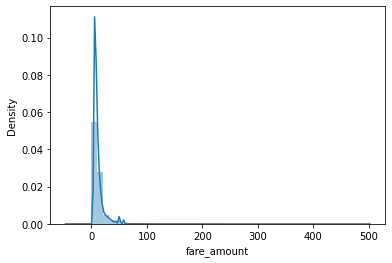

In [118]:
sns.distplot(df['fare_amount'])

##### Здесь видно, что поездки в основном стоили до ~0. Работаем с поездками с положительной суммой (&#36;0+)

In [139]:
df = df[df['fare_amount'].between(1, 80)]

/home/xeno/anaconda3/envs/rstudio/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='fare_amount', ylabel='Density'>

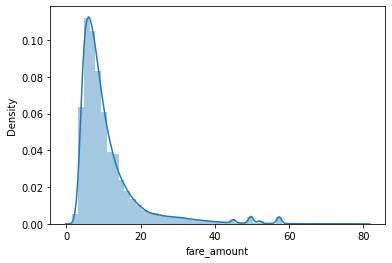

In [140]:
sns.distplot(df['fare_amount'])

##### Узнаём коорлинаты границ города, чтобы исключить слишком далёкие строчки. Берём из Вики: https://en.wikipedia.org/wiki/Module:Location_map/data/USA_New_York_City_Subway

In [121]:
df['pickup_latitude']

0         40.721319
1         40.711303
2         40.761270
3         40.733143
4         40.768008
            ...    
999995    40.785630
999996    40.671385
999997    40.751135
999998    40.759482
999999    40.741598
Name: pickup_latitude, Length: 996321, dtype: float64

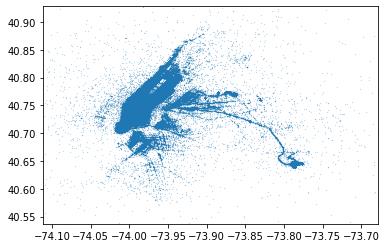

In [136]:
longitude_limit = (-74.112, -73.679)
latitude_limit = (40.537, 40.928)

plt.ylim(latitude_limit)
plt.xlim(longitude_limit)

longitude = df['pickup_longitude']
latitude = df['pickup_latitude']

plt.scatter(longitude, latitude, s=0.01)

#plt.savefig('nyc_scatter_lo_res_dot.png', dpi=1000, facecolor='w', edgecolor='w',
    #orientation='portrait', format=None,
    #transparent=False, bbox_inches=None, pad_inches=0.1,)'''

##### Диаграмма показывает, что аэропорты бывают высоко загружены, что мы возьмём на учёт. Зададим координаты 3 аэропортов Нью-Йорка и напишем функцию, которая будет присваивать 1 колонке 'аэропорт', если заказ на территорию аэропорта

In [134]:
nyc_airports={'JFK':{'min_lng':-73.835,
                     'min_lat':40.619,
                     'max_lng':-73.740, 
                     'max_lat':40.665},
              
              'EWR':{'min_lng':-74.192,
                     'min_lat':40.670, 
                     'max_lng':-74.153, 
                     'max_lat':40.708},
              
        'LaGuardia':{'min_lng':-73.889, 
                     'min_lat':40.766, 
                     'max_lng':-73.855, 
                     'max_lat':40.793}
                }

def airport(latitude, longitude, airport_name):
    if (latitude >= nyc_airports[airport_name]['min_lat'] and
      latitude <= nyc_airports[airport_name]['max_lat'] and
      longitude >= nyc_airports[airport_name]['min_lng'] and
      longitude <= nyc_airports[airport_name]['max_lng']):
        return 1
    else:
        return 0